<a href="https://colab.research.google.com/github/Deleon57/EDAR-Data/blob/main/KNN222.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [38]:
import yfinance as yf
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Get Data

In [39]:
ticker = "GFI.JO"
data = yf.download(ticker, start="2013-01-01", end="2024-12-31")

data.reset_index(inplace=True)
data.head(10)

/tmp/ipython-input-3713280938.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2013-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO
0,2013-01-01,9091.964844,9091.964844,9091.964844,9091.964844,0
1,2013-01-02,9323.317383,9325.945528,9043.766744,9151.555749,2277190
2,2013-01-03,9335.583008,9376.771228,9183.977665,9289.137525,1638359
3,2013-01-04,9049.024414,9131.399905,8955.256723,9113.873744,2154183
4,2013-01-07,9104.232422,9156.811871,9000.824970,9083.200447,1833898
5,2013-01-08,8928.091797,9148.051381,8900.925854,9013.972140,2221997
6,2013-01-09,9006.961914,9037.633676,8860.614741,9020.983235,2344840
7,2013-01-10,9091.964844,9091.964844,8906.181888,8982.423416,1564839
8,2013-01-11,9201.507812,9240.066932,9112.998347,9113.875045,3899959


# Feature engineer

In [40]:
df = data.copy()

# 1. Spreads
df['High_Low'] = df['High'] - df['Low']
df['Open_Close'] = df['Open'] - df['Close']

# 2. Moving Averages
df['SMA_5'] = df['Close'].rolling(5).mean()
df['SMA_10'] = df['Close'].rolling(10).mean()
df['SMA_20'] = df['Close'].rolling(20).mean()
df['SMA_50'] = df['Close'].rolling(50).mean()
df['SMA_100'] = df['Close'].rolling(100).mean()
df['SMA_200'] = df['Close'].rolling(200).mean()

# 3. Exponential Moving Averages
df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

# 4. Rolling Std (Volatility)
df['RollingStd_20'] = df['Close'].rolling(20).std()

# 5. Lag Features (Close & Volume)
for lag in range(1, 6):
    df[f'Close_t-{lag}'] = df['Close'].shift(lag)
    df[f'Volume_t-{lag}'] = df['Volume'].shift(lag)
    df[f'Return_t-{lag}'] = df['Close'].pct_change(lag)

# 6. Relative Strength Index (RSI)
window_length = 14
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
rs = gain / loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# 7. On-Balance Volume (OBV)
df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

# 8. Moving Average Convergence Divergence (MACD)
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# 9. Bollinger Bands (20-day)
df['BB_Middle'] = df['Close'].rolling(window=20).mean()

# 10. Average True Range (ATR)
df['H-L'] = df['High'] - df['Low']
df['H-C'] = abs(df['High'] - df['Close'].shift())
df['L-C'] = abs(df['Low'] - df['Close'].shift())
df['TR'] = df[['H-L', 'H-C', 'L-C']].max(axis=1)
df['ATR_14'] = df['TR'].rolling(14).mean()

# Drop NA rows
df.dropna(inplace=True)

# Target: 1 if next-day close > today’s close, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

df.dropna(inplace=True)
df.head(10)

Price,Date,Close,High,Low,Open,Volume,High_Low,Open_Close,SMA_5,SMA_10,...,EMA_26,MACD,Signal_Line,BB_Middle,H-L,H-C,L-C,TR,ATR_14,Target
Ticker,,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,,,,,...,,,,,,,,,,
199,2013-10-07,4485.152832,4575.933283,4452.232449,4479.167308,1173121,123.700834,-5.985524,4500.716016,4591.396924,...,4838.440268,-222.953690,-231.006134,4695.545068,123.700834,80.802912,42.897922,123.700834,162.749117,0
200,2013-10-08,4451.235352,4556.979625,4449.240177,4556.979625,1274177,107.739448,105.744273,4497.124805,4562.067822,...,4809.758423,-219.541264,-228.713160,4660.230469,107.739448,71.826793,35.912655,107.739448,163.532935,0
201,2013-10-09,4380.407227,4470.190112,4355.467536,4464.204586,1392042,114.722576,83.797360,4467.995313,4531.242334,...,4777.954630,-220.015923,-226.973712,4627.858740,114.722576,18.954761,95.767815,114.722576,146.859031,1
202,2013-10-10,4442.256836,4468.194109,4301.597008,4375.418478,1802995,166.597101,-66.838358,4450.836523,4506.402344,...,4753.088127,-212.946630,-224.168296,4609.902100,166.597101,87.786883,78.810219,166.597101,139.662214,0
203,2013-10-11,4336.513672,4429.289327,4302.595691,4406.344810,1050501,126.693636,69.831138,4419.113184,4471.187500,...,4722.230760,-213.416621,-222.017961,4590.299512,126.693636,12.967509,139.661145,139.661145,134.959222,1
204,2013-10-14,4399.360840,4436.271577,4279.650341,4321.549015,2032833,156.621236,-77.811824,4401.954785,4451.335400,...,4698.314470,-206.339300,-218.882229,4578.079028,156.621236,99.757905,56.863331,156.621236,146.146453,0
205,2013-10-15,4336.513672,4406.344810,4271.670472,4372.426829,2081226,134.674338,35.913157,4379.010449,4438.067627,...,4671.514411,-203.456394,-215.797062,4561.519141,134.674338,6.983970,127.690368,134.674338,143.224993,1
206,2013-10-16,4369.434570,4488.147519,4344.494875,4366.441807,2451447,143.652643,-2.992763,4376.815918,4422.405615,...,4649.138126,-196.252948,-211.888239,4545.557764,143.652643,151.633847,7.981203,151.633847,143.723825,1
207,2013-10-17,4424.300781,4424.300781,4289.626462,4329.529964,7904643,134.674319,-94.770817,4373.224707,4412.030615,...,4632.483508,-183.995929,-206.309777,4521.665552,134.674319,54.866211,79.808108,134.674319,142.940005,1


# Preprocessing the data

In [41]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# --- Feature groups ---
price_cols = [
    'Open','High','Low','Close',
    'SMA_5','SMA_10','SMA_20','SMA_50','SMA_100','SMA_200',
    'EMA_5','EMA_12','EMA_20','EMA_26','EMA_50','BB_Middle'
]

volume_cols = ['Volume']   # only raw volume gets log transform
obv_cols = ['OBV']         # OBV can be negative → no log, just scale

relative_cols = [
    'High_Low','Open_Close',
    'Return_t-1','Return_t-2','Return_t-3','Return_t-4','Return_t-5',
    'MACD','Signal_Line','ATR_14','H-L','H-C','L-C','TR'
]

bounded_cols = ['RSI_14']   # already in 0–100

# --- Copy data ---
X_train_scaled = X_train_full.copy()
X_test_scaled = X_test_full.copy()

# --- 1. Prices & MAs -> MinMax 0–100 ---
price_scaler = MinMaxScaler(feature_range=(0,100))
X_train_scaled[price_cols] = price_scaler.fit_transform(X_train_full[price_cols])
X_test_scaled[price_cols] = price_scaler.transform(X_test_full[price_cols])

# --- 2. Volume -> log + MinMax 0–100 ---
X_train_scaled['Volume'] = np.log1p(X_train_full['Volume'])
X_test_scaled['Volume'] = np.log1p(X_test_full['Volume'])

vol_scaler = MinMaxScaler(feature_range=(0,100))
X_train_scaled[['Volume']] = vol_scaler.fit_transform(X_train_scaled[['Volume']])
X_test_scaled[['Volume']] = vol_scaler.transform(X_test_scaled[['Volume']])

# --- 3. OBV (can be negative) -> MinMax directly ---
obv_scaler = MinMaxScaler(feature_range=(0,100))
X_train_scaled[['OBV']] = obv_scaler.fit_transform(X_train_full[['OBV']].values.reshape(-1,1))
X_test_scaled[['OBV']] = obv_scaler.transform(X_test_full[['OBV']].values.reshape(-1,1))

# --- 4. Relative cols -> MinMax 0–100 ---
rel_scaler = MinMaxScaler(feature_range=(0,100))
X_train_scaled[relative_cols] = rel_scaler.fit_transform(X_train_full[relative_cols])
X_test_scaled[relative_cols] = rel_scaler.transform(X_test_full[relative_cols])

# --- 5. RSI (already 0–100) left as-is ---
X_train_scaled[bounded_cols] = X_train_full[bounded_cols]
X_test_scaled[bounded_cols] = X_test_full[bounded_cols]

# --- Preview ---
print("Scaled training data sample:")
display(X_train_scaled.head())


Scaled training data sample:


Price,Open,High,Low,Close,Volume,SMA_5,SMA_10,SMA_20,SMA_50,SMA_100,...,EMA_12,EMA_26,MACD,Signal_Line,BB_Middle,H-L,H-C,L-C,TR,ATR_14
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,,,,,,...,,,,,,,,,,
199,4.997217,5.020311,5.268375,4.767673,82.003165,4.790497,4.996734,5.269027,6.812023,7.270125,...,4.817547,5.330537,36.702308,34.951765,5.269027,1.707482,1.772428,1.053811,1.707482,4.741697
200,5.267984,4.956147,5.257571,4.651519,82.488035,4.777557,4.889489,5.136421,6.698683,7.226074,...,4.723175,5.220493,36.792237,35.018165,5.136421,1.487162,1.575535,0.882214,1.487162,4.787817
201,4.945151,4.662337,4.918972,4.408962,83.007164,4.672604,4.776773,5.014866,6.584483,7.175158,...,4.602628,5.098471,36.779728,35.068535,5.014866,1.583552,0.415776,2.352588,1.583552,3.806725
202,4.636198,4.655580,4.724453,4.620771,84.525023,4.610781,4.685943,4.947439,6.464881,7.124410,...,4.536163,5.003066,36.966029,35.149774,4.947439,2.299593,1.925623,1.936015,2.299593,3.383265
203,4.743814,4.523875,4.728060,4.258644,81.355360,4.496481,4.557176,4.873831,6.361326,7.074252,...,4.419168,4.884675,36.953643,35.212043,4.873831,1.748793,0.284445,3.430851,1.927787,3.106541


#Train and split data

In [42]:
train = df[df['Date'] < "2024-01-01"]
test = df[df['Date'] >= "2024-01-01"]

feature_pool = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'SMA_5','SMA_10','SMA_20','SMA_50','SMA_100','SMA_200',
    'EMA_5','EMA_20','EMA_50',
    'RollingStd_20','High_Low','Open_Close',
    'Close_t-1','Close_t-2','Close_t-3','Close_t-4','Close_t-5',
    'Volume_t-1','Volume_t-2','Volume_t-3','Volume_t-4','Volume_t-5',
    'Return_t-1','Return_t-2','Return_t-3','Return_t-4','Return_t-5',
    'RSI_14',
    'OBV','EMA_12','EMA_26','MACD','Signal_Line','BB_Middle',
    'H-L','H-C','L-C','TR','ATR_14'
]
X_train_full = train[feature_pool]
y_train = train['Target']
X_test_full = test[feature_pool]
y_test = test['Target']


# Standardize feature

# Search for best combination of features that will have highest accuracy

In [56]:
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

best_score = 0
best_features = None
best_model = None

random.seed(42)  # reproducibility

for _ in range(300):
    r = random.randint(4, 5)  # choose random number of features
    combo = random.sample(feature_pool, r)  # choose random subset

    # use scaled data
    X_train = X_train_scaled[list(combo)]
    X_test = X_test_scaled[list(combo)]

    # train KNN
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)

    # evaluate
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)

    # track best
    if acc > best_score:
        best_score = acc
        best_features = combo
        best_model = model

print("Best Accuracy:", best_score)
print("Best Feature Set:", best_features)


Best Accuracy: 0.5783132530120482
Best Feature Set: ['L-C', 'EMA_12', 'Open', 'SMA_5']


# Confusion matrix

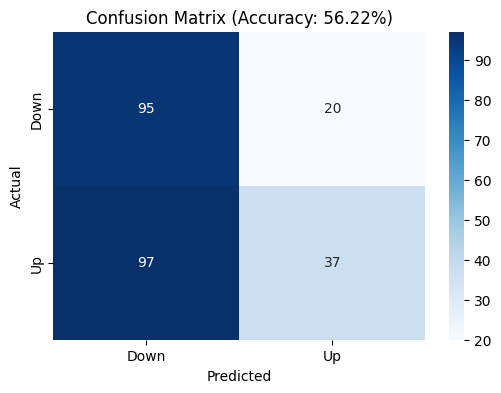

In [48]:
X_test_best = X_test_full[list(best_features)]
y_pred = best_model.predict(X_test_best)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down","Up"], yticklabels=["Down","Up"])
plt.title(f"Confusion Matrix (Accuracy: {best_score:.2%})")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


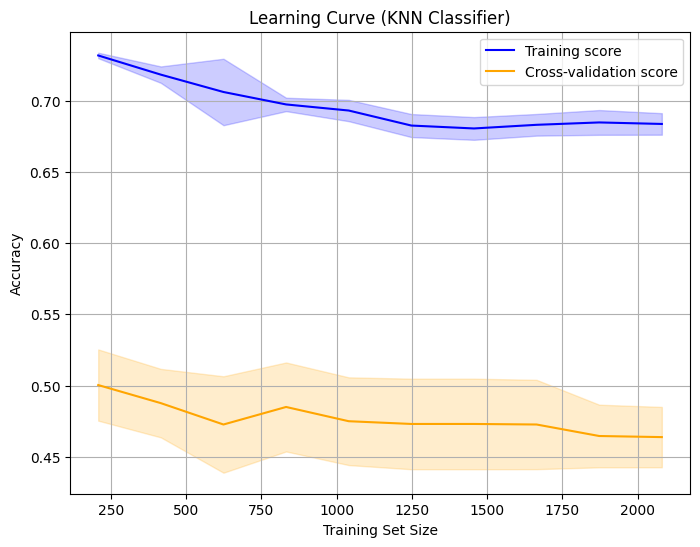

In [45]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model,
    X_train_full[list(best_features)],
    y_train,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="Training score", color="blue")
plt.plot(train_sizes, test_mean, label="Cross-validation score", color="orange")

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2, color="orange")

plt.title("Learning Curve (KNN Classifier)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()


# Search for best value of k

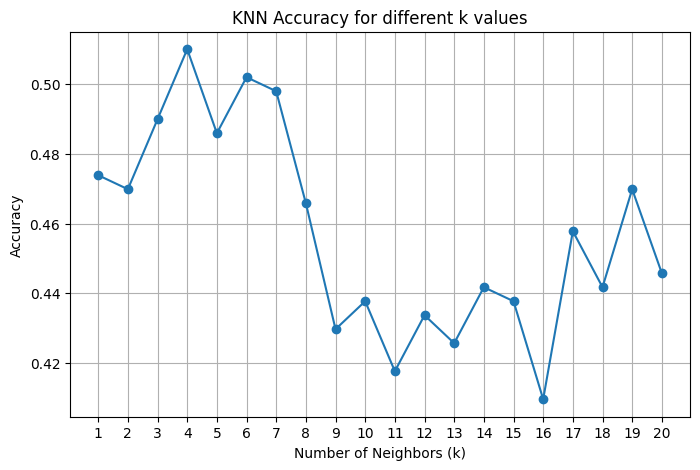

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

k_values = range(1, 21)
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    scores.append(acc)

plt.figure(figsize=(8,5))
plt.plot(k_values, scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy for different k values')
plt.xticks(k_values)
plt.grid(True)
plt.show()

best_k = k_values[scores.index(max(scores))]
